<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project: Web APIs & NLP

## Problem Statement

We are a group of home improvement consultants that provide suggestions on how to refurbish the houses in selected neighborhoods in Ames, Iowa, including selecting the best features for homeowners to renovate, in order to improve the value of their homes in a cost-effective way.

Based on the provided data, we will:
- build several multiple linear regression models and select one best-performing model as our production model
- based on our production model, explore and  recommend important features for home improvment
- build models for selected neighorboods, explore and  recommend important features for home improvment

## Background

House value are influented by the following factors:([*source*](https://www.opendoor.com/w/blog/factors-that-influence-home-value))
- Neighborhood comps
- Location
- Home size and usable space
- Age and condition
- Upgrades and updates
- The local market
- Economic indicators
- Interest rates

As home improvement consultants, we are more interested at the factors or features which can be improved on the exsiting houses. 


## Dataset and Data Directory
- The dataset  ([*source*](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data)) contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010.
- The Dataset has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). ([*source*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))
- Some important features are listed as below 


|Feature|Type|Description|
|---|---|---|
|**SalePrice**|*Continuous*|sale price, we will treat it as house value| 
|**Neighborhood**|*nominal*|Physical locations within Ames city limits|
|**Overall Qual**|*ordinal*|Rates the overall material and finish of the house|
|**Year Built**|*Discrete*|Original construction date|
|**Mas Vnr Type**|*nominal*|Masonry veneer type|
|**Mas Vnr Area**|*Continuous*|PMasonry veneer area in square feet|
|**Foundation**|*Nominal*| Type of foundation|
|**BsmtFin Type 1**|*Ordinal*| Rating of basement finished area| 
|**BsmtFin SF 1**|*Continuous*|Type 1 finished square feet|
|**Total Bsmt SF**|*Continuous*|Total square feet of basement area|
|**Gr Liv Area**|*Continuous*|Above grade (ground) living area square feet|
|**Fireplaces**|*Discrete*|Number of fireplaces|
|**Garage Area**|*Continuous*|Size of garage in square feet|
|**Open Porch SF**|*Continuous*| Open porch area in square feet|
|**HeatingQC**|*Ordinal*|Heating quality and condition|
|**Bedroom**|*Discrete*|Bedrooms above grade (does NOT include basement bedrooms)|
|**Kitchen**|*Discrete*|Kitchens above grade|
|**KitchenQual**|*Ordinal*|Kitchen quality|
|**TotRmsAbvGrd**|*Discrete*|Total rooms above grade (does not include bathrooms)|


In [121]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [122]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB,ComplementNB,GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler
from sklearn.inspection import partial_dependence,PartialDependenceDisplay




import pickle
import requests
import time



# define some functions

In [153]:
def get_top_ngram(corpus,  n_gram=1, top_n=10):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    x,y=map(list,zip(*(words_freq[:top_n])))
    sns.barplot(x=y,y=x)
    return words_freq[:top_n]

In [124]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(15, 8))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

In [125]:
def run_model(gs, X_train, y_train, X_test, y_test ):
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    perc_diff = np.abs(test_score/train_score*100-100)
    
    print(f'score on training set: {train_score:.3f}')
    print(f'score on testing set: {test_score:.3f}')
    print(f'perc_diff: {perc_diff:.1f} %')
    
    
    # Get predictions
    preds = gs.predict(X_test)
    # Save confusion matrix values
    cm = confusion_matrix(y_test, preds)
    cm_df = pd.DataFrame(cm, columns=['pred AskWomen', 'pred AskMen'], 
                         index=['actual AskWomen', 'actual AskMen'])
    print(cm_df.head())
                    
        
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=[10,5])
    
    # View confusion matrix
    #plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, ax=ax1)
    ax1.set_title("confusion matrix")
    
    #plot ROC curve
    #define metrics
    y_pred_proba = gs.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

    #create ROC curve
   # fig = plt.figure(1, figsize=(12, 12))
    ax2.plot(fpr,tpr)
    ax2.set_title("ROC corve")
    ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    #ax2.ylabel('True Positive Rate')
    #ax2.xlabel('False Positive Rate')
    plt.show()

# pickle

In [126]:
pick_dict = pickle.load(open('../datasets/data.pkl', 'rb'))

In [127]:
df_askwomen = pick_dict['df_askwomen']
print(df_askwomen.shape)
df_askwomen.head()

(1999, 70)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_template_id,author_flair_text_color,author_flair_background_color,banned_by,author_cakeday,post_hint,preview,call_to_action,category
0,[],False,naughtygeekyredditor,None,[],None,text,t2_6ch7kb03,False,False,False,[],False,False,1658491375,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58vxv,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,True,all_ads,/r/AskWomen/comments/w58vxv/how_often_do_you_m...,False,6,automod_filtered,1658491386,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822025,public,top,nsfw,How often do you masturbate?,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,promo_adult_nsfw,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491121,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58shp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58shp/how_would_you_hear...,False,6,moderator,1658491132,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822016,public,top,self,How would you hear “No one could ever be as at...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,kia-audi-spider-legs,None,[],None,text,t2_kjkrn8oa,False,False,False,[],False,False,1658491016,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58rbp,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskWomen/comments/w58rbp/no_one_could_ever_...,False,6,moderator,1658491027,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822012,public,top,self,“No one could ever be as attracted to you as I...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,tsbxred,female,[],♀,text,t2_om297,False,False,False,[],False,False,1658490938,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58qi4,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58qi4/what_is_your_exper...,False,6,automod_filtered,1658490949,1,[removed],True,False,False,AskWomen,t5_2rxrw,3822007,public,top,self,What is your experience of staying with a miso...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,8106c61a-c8aa-11e1-a771-12313b0ce1e2,dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Spiritual-Ad8437,None,[],None,text,t2_7xt6wpkw,False,False,False,[],False,False,1658490589,self.AskWomen,https://www.reddit.com/r/AskWomen/comments/w58...,{},w58mnf,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskWomen/comments/w58mnf/why_is_it_more_soc...,False,6,automod_filtered,1658490600,1,[removed],True,False,False,AskWomen,t5_2rxrw,3821993,public,top,self,Why is it more socially acceptable when a woma...,0,[],1.00,https://www.reddit.com/r/AskWomen/comments/w58...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
df_askmen = pick_dict['df_askmen']
print(df_askmen.shape)
df_askmen.head()

(2000, 67)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_flair_background_color,author_flair_template_id,author_flair_text_color,banned_by,post_hint,preview,author_cakeday
0,[],False,capuccinohedgie,None,[],None,text,t2_8q465stc,False,False,False,[],False,False,1658491492,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58xe...,{},w58xer,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58xer/is_wearing_a_wig_a_t...,False,6,moderator,1658491502,1,[removed],True,False,False,AskMen,t5_2s30g,4000940,public,self,Is wearing a wig a turn off,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58xe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,wondroussarah,None,[],None,text,t2_976wlsse,False,False,False,[],False,False,1658491238,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58u6...,{},w58u6v,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58u6v/do_men_come_up_to_mo...,False,6,moderator,1658491249,1,[removed],True,False,False,AskMen,t5_2s30g,4000934,public,self,Do men come up to MOST women to ask for relati...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58u6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Commercial_Fuel_3519,None,[],None,text,t2_3l9elkem,False,False,False,[],False,False,1658490909,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58q6...,{},w58q67,False,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58q67/you_have_a_16_year_o...,False,6,NaN,1658490920,1,,True,False,False,AskMen,t5_2s30g,4000920,public,self,You have a 16 year old daughter who generally ...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58q6...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,ZoneWestern464,None,[],None,text,t2_eu514prg,False,False,False,[],False,False,1658490844,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pg...,{},w58pg8,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,1,0,False,all_ads,/r/AskMen/comments/w58pg8/mods_are_vir/,False,6,moderator,1658490855,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,mods are vir....,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pg...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Recent-Manager-9875,None,[],None,text,t2_pemzjrr2,False,False,False,[],False,False,1658490840,self.AskMen,https://www.reddit.com/r/AskMen/comments/w58pe...,{},w58peh,False,False,False,False,False,False,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AskMen/comments/w58peh/do_you_have_a_specif...,False,6,moderator,1658490850,1,[removed],True,False,False,AskMen,t5_2s30g,4000920,public,self,Do you have a specific hair routine and what k...,0,[],1.00,https://www.reddit.com/r/AskMen/comments/w58pe...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
df_askwomen = df_askwomen.loc[:,['subreddit','author', 'title','selftext']]

In [130]:
df_askmen = df_askmen.loc[:,['subreddit', 'author', 'title','selftext']]

## Data cleaning and EDA : df_askwomen

### handle null values

In [131]:
df_askwomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1999 non-null   object
 1   author     1999 non-null   object
 2   title      1999 non-null   object
 3   selftext   1992 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [132]:
(df_askwomen.isnull().sum()/len(df_askwomen)*100).sort_values(ascending=False)

selftext    0.35
subreddit   0.00
author      0.00
title       0.00
dtype: float64

In [133]:
df_askwomen['selftext']=df_askwomen['selftext'].fillna('')

In [134]:
(df_askwomen.isnull().sum()/len(df_askwomen)*100).sort_values(ascending=False)

subreddit   0.00
author      0.00
title       0.00
selftext    0.00
dtype: float64

In [135]:
df_askwomen['selftext']=df_askwomen['selftext'].astype("str")

## EDA: 'title'

Text(0, 0.5, 'count')

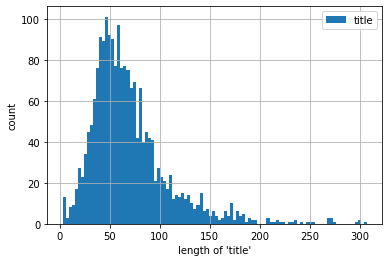

In [136]:
ax = df_askwomen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")

In [137]:
#df_askwomen.sort_values(by='title', ascending=True, inplace=True)
df_askwomen[df_askwomen['title'].str.len()<15]

,subreddit,author,title,selftext
9,AskWomen,Zostrianos_696,Why victims?,[removed]
72,AskWomen,ygphohunnid,Who can help??,[removed]
74,AskWomen,SmellResponsible2816,what is this,[removed]
117,AskWomen,charismaticlass,what do i do?,[removed]
209,AskWomen,MJB4890,Which one,[removed]
252,AskWomen,No-Toe-1966,why?,[removed]
253,AskWomen,No-Toe-1966,why,[removed]
263,AskWomen,No_Principle_8660,tell me why,[removed]
384,AskWomen,mommypiage,who's next?,[removed]
407,AskWomen,tomybestself,What is a man?,[removed]


In [138]:
df_askwomen.shape

(1999, 4)

In [139]:
#delete records with len('title') < 15
df_askwomen = df_askwomen[df_askwomen['title'].str.len()>15]
df_askwomen.shape

(1966, 4)

#### EDA : 'selftext'


Text(0, 0.5, 'count')

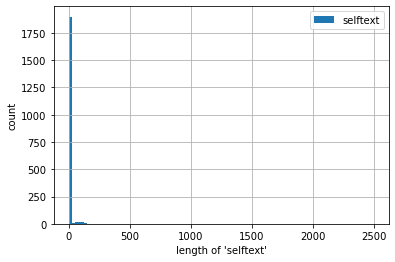

In [140]:
ax = df_askwomen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")

In [141]:
df_askwomen[df_askwomen['selftext'].str.len()<15]

,subreddit,author,title,selftext
0,AskWomen,naughtygeekyredditor,How often do you masturbate?,[removed]
1,AskWomen,kia-audi-spider-legs,How would you hear “No one could ever be as at...,[removed]
2,AskWomen,kia-audi-spider-legs,“No one could ever be as attracted to you as I...,[removed]
3,AskWomen,tsbxred,What is your experience of staying with a miso...,[removed]
4,AskWomen,Spiritual-Ad8437,Why is it more socially acceptable when a woma...,[removed]
...,...,...,...,...
1994,AskWomen,UltimateSeductive,What is the worst response I could get to the ...,[removed]
1995,AskWomen,Certain_Dark6013,Why do so many women have no problem with adul...,[removed]
1996,AskWomen,Loki_8456,How do you feel meeting people online vs in pe...,[removed]
1997,AskWomen,LordoftheRingbeef,45(M) how do i tell my wife 44(F) that she isn...,[removed]


In [142]:
df_askwomen['selftext'].replace('[removed]','', inplace=True, regex=True)


In [143]:
df_askwomen[df_askwomen['selftext'].str.contains('[removed]')].count()

subreddit    0
author       0
title        0
selftext     0
dtype: int64

### create new column 'title + selftext'

In [145]:
df_askwomen['title + selftext'] = df_askwomen['title'] + df_askwomen['selftext']
df_askwomen.head()

,subreddit,author,title,selftext,title + selftext
0,AskWomen,naughtygeekyredditor,How often do you masturbate?,[],How often do you masturbate?[]
1,AskWomen,kia-audi-spider-legs,How would you hear “No one could ever be as at...,[],How would you hear “No one could ever be as at...
2,AskWomen,kia-audi-spider-legs,“No one could ever be as attracted to you as I...,[],“No one could ever be as attracted to you as I...
3,AskWomen,tsbxred,What is your experience of staying with a miso...,[],What is your experience of staying with a miso...
4,AskWomen,Spiritual-Ad8437,Why is it more socially acceptable when a woma...,[],Why is it more socially acceptable when a woma...


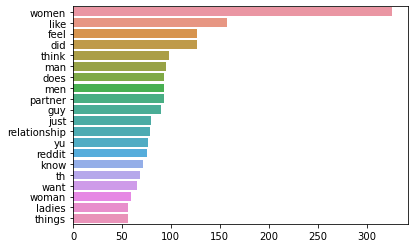

In [158]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=1, top_n=20)


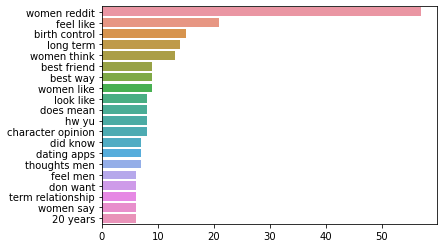

In [159]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=2, top_n=20)

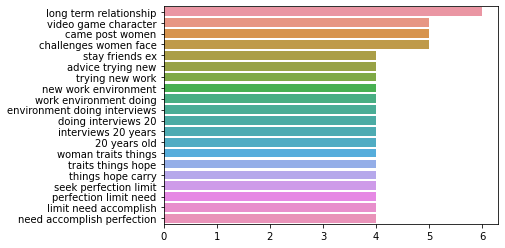

In [160]:
corpus=df_askwomen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=3, top_n=20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


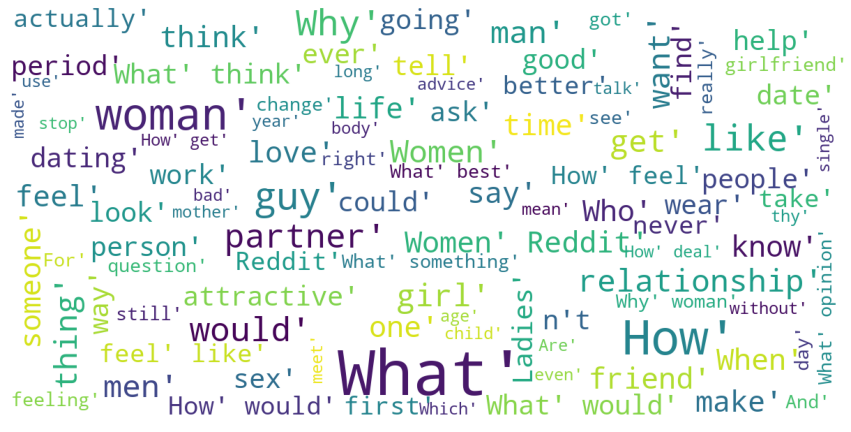

In [161]:
plot_wordcloud(df_askwomen['title + selftext'])

## Data cleaning and EDA : df_askmen

### handle null values

In [162]:
df_askmen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2000 non-null   object
 1   author     2000 non-null   object
 2   title      2000 non-null   object
 3   selftext   1979 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [163]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

selftext    1.05
subreddit   0.00
author      0.00
title       0.00
dtype: float64

In [164]:
df_askmen['selftext']=df_askmen['selftext'].fillna('')

In [165]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

subreddit   0.00
author      0.00
title       0.00
selftext    0.00
dtype: float64

In [166]:
df_askmen['selftext']=df_askmen['selftext'].astype("str")

## EDA: 'title'

Text(0, 0.5, 'count')

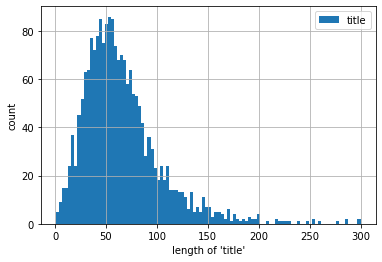

In [167]:
ax = df_askmen['title'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'title'")
ax.set_ylabel("count")

In [169]:
#df_askwomen.sort_values(by='title', ascending=True, inplace=True)
df_askmen[df_askmen['title'].str.len()<10]

,subreddit,author,title,selftext
101,AskMen,Patient_Ad_7265,Help,[removed]
113,AskMen,PsychologicalBee2031,Help me.,[removed]
137,AskMen,No_Victory_1513,Cooking,[removed]
186,AskMen,lykme2,Why???,[removed]
241,AskMen,shego3,Venting,[removed]
468,AskMen,111riot,wha,[removed]
473,AskMen,Practical_Pension421,DM,[removed]
474,AskMen,Practical_Pension421,s,[removed]
515,AskMen,Febastroph,Nsfw,[removed]
540,AskMen,ocdinmymind,help pls,[removed]


In [171]:
df_askmen.shape

(2000, 4)

In [172]:
#delete records with len('title') < 15
df_askmen = df_askmen[df_askmen['title'].str.len()>10]
df_askmen.shape

(1967, 4)

#### EDA : 'selftext'


Text(0, 0.5, 'count')

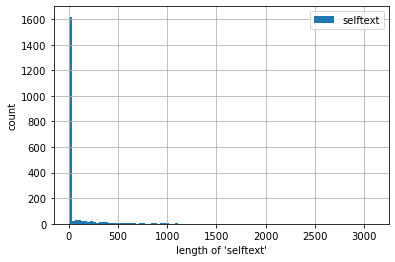

In [173]:
ax = df_askmen['selftext'].str.len().hist(bins=100,legend=True)
ax.set_xlabel("length of 'selftext'")
ax.set_ylabel("count")

In [174]:
df_askmen[df_askmen['selftext'].str.len()<15]

,subreddit,author,title,selftext
0,AskMen,capuccinohedgie,Is wearing a wig a turn off,[removed]
1,AskMen,wondroussarah,Do men come up to MOST women to ask for relati...,[removed]
2,AskMen,Commercial_Fuel_3519,You have a 16 year old daughter who generally ...,
3,AskMen,ZoneWestern464,mods are vir....,[removed]
4,AskMen,Recent-Manager-9875,Do you have a specific hair routine and what k...,[removed]
...,...,...,...,...
1995,AskMen,skinticket02,Men ( both gay and straight) are a lot more sh...,
1996,AskMen,Sofia_Andre_OF,What sexual desires/preferences are you afraid...,[removed]
1997,AskMen,manhadz,When has waiting for the “girl of your dreams”...,
1998,AskMen,Any-Discussion-5934,Why do some men keep calling themselves STRAIG...,[removed]


In [175]:
df_askmen['selftext'].replace('[removed]','', inplace=True, regex=True)


In [177]:
df_askmen[df_askmen['selftext'].str.contains('[removed]')].count()

subreddit    0
author       0
title        0
selftext     0
dtype: int64

### create new column 'title + selftext'

In [178]:
df_askmen['title + selftext'] = df_askmen['title'] + df_askmen['selftext']
df_askmen.head()

,subreddit,author,title,selftext,title + selftext
0,AskMen,capuccinohedgie,Is wearing a wig a turn off,[],Is wearing a wig a turn off[]
1,AskMen,wondroussarah,Do men come up to MOST women to ask for relati...,[],Do men come up to MOST women to ask for relati...
2,AskMen,Commercial_Fuel_3519,You have a 16 year old daughter who generally ...,,You have a 16 year old daughter who generally ...
3,AskMen,ZoneWestern464,mods are vir....,[],mods are vir....[]
4,AskMen,Recent-Manager-9875,Do you have a specific hair routine and what k...,[],Do you have a specific hair routine and what k...


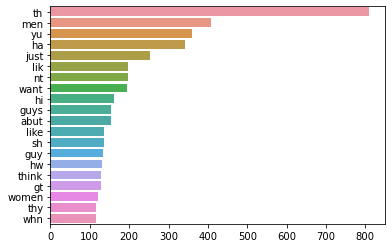

In [179]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=1, top_n=20)


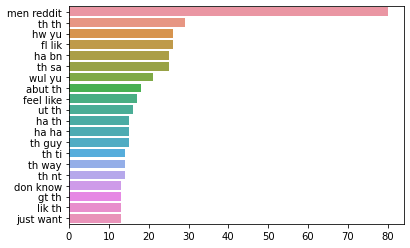

In [180]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=2, top_n=20)

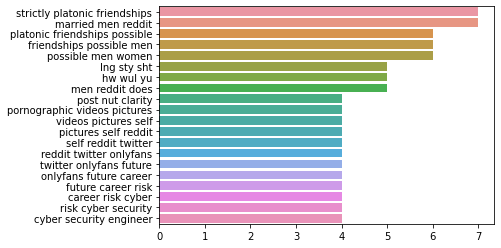

In [181]:
corpus=df_askmen['title + selftext']
top_n_bigrams=get_top_ngram(corpus, n_gram=3, top_n=20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


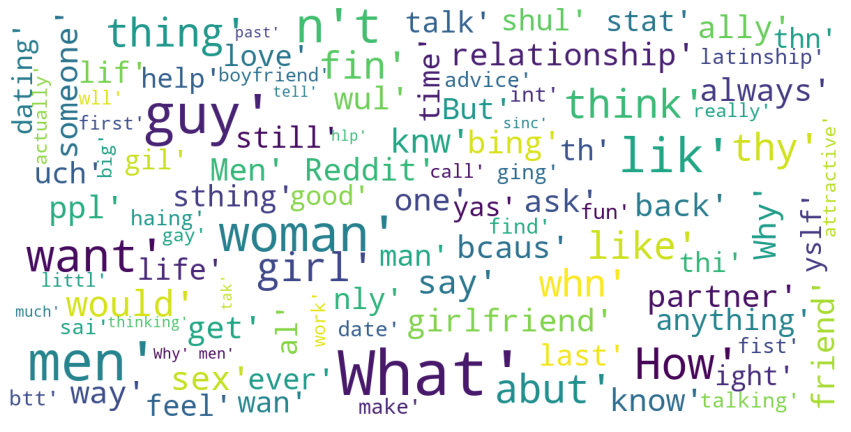

In [182]:
plot_wordcloud(df_askmen['title + selftext'])

In [53]:
df_askwomen[df_askwomen['title + selftext'].str.len()<15]

,subreddit,author,title,selftext,title + selftext


In [361]:
#delete rows with len('title + selftext')<15
df_askwomen = df_askwomen[df_askwomen['title + selftext'].str.len()>15]

In [38]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

selftext    1.05
subreddit   0.00
author      0.00
title       0.00
dtype: float64

In [39]:
df_askmen['selftext']=df_askmen['selftext'].fillna('')

In [40]:
(df_askmen.isnull().sum()/len(df_askmen)*100).sort_values(ascending=False)

subreddit   0.00
author      0.00
title       0.00
selftext    0.00
dtype: float64

In [41]:
df_askmen['selftext']=df_askmen['selftext'].astype("str")

In [42]:
df_askmen[df_askmen['selftext'].str.contains('[removed]')].count()

subreddit    1536
author       1536
title        1536
selftext     1536
dtype: int64

In [43]:
df_askmen['selftext'].replace('[removed]','', inplace=True)

<AxesSubplot:>

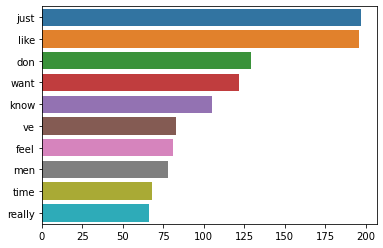

In [44]:
top_n_bigrams=get_top_ngram(df_askmen['selftext'], n=1)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

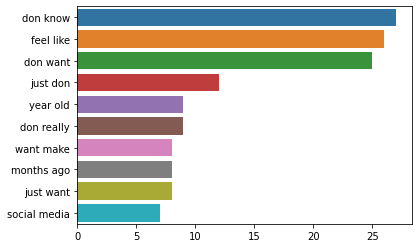

In [47]:
top_n_bigrams=get_top_ngram(df_askmen['selftext'], n=2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


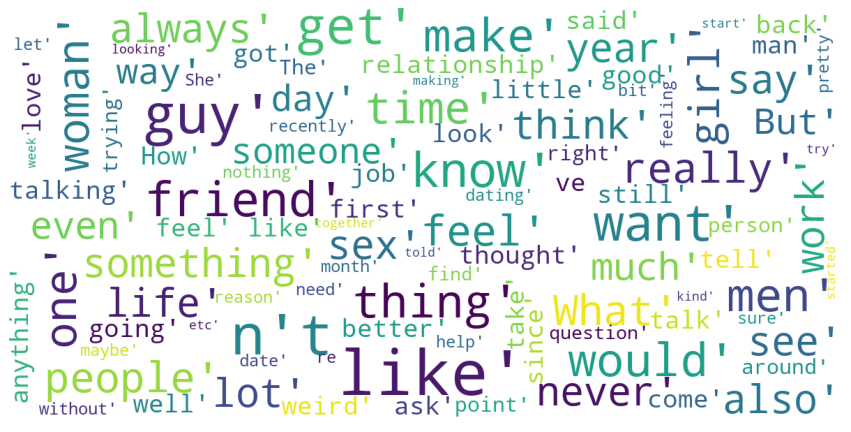

In [45]:
plot_wordcloud(df_askmen['selftext'])

In [46]:
df_askwomen['title + selftext'] = df_askwomen['title'] + df_askwomen['selftext']

<AxesSubplot:>

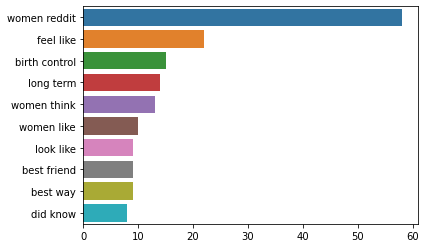

In [353]:
top_n_bigrams=get_top_ngram(df_askwomen['title + selftext'], n=2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


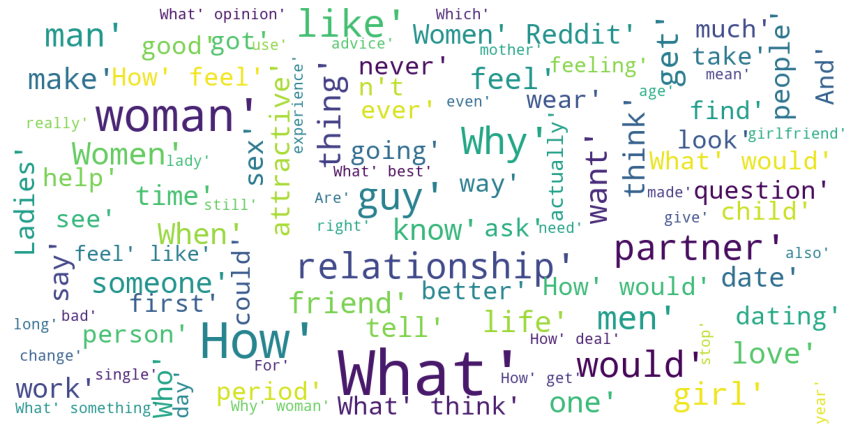

In [48]:
plot_wordcloud(df_askwomen['title + selftext'])

In [49]:
df_askmen['title + selftext'] = df_askmen['title'] + df_askmen['selftext']

<AxesSubplot:>

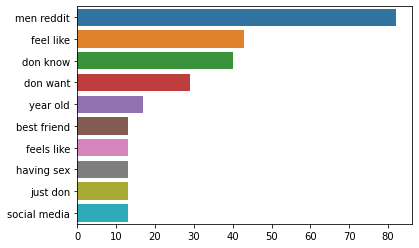

In [50]:
top_n_bigrams=get_top_ngram(df_askmen['title + selftext'], n=2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


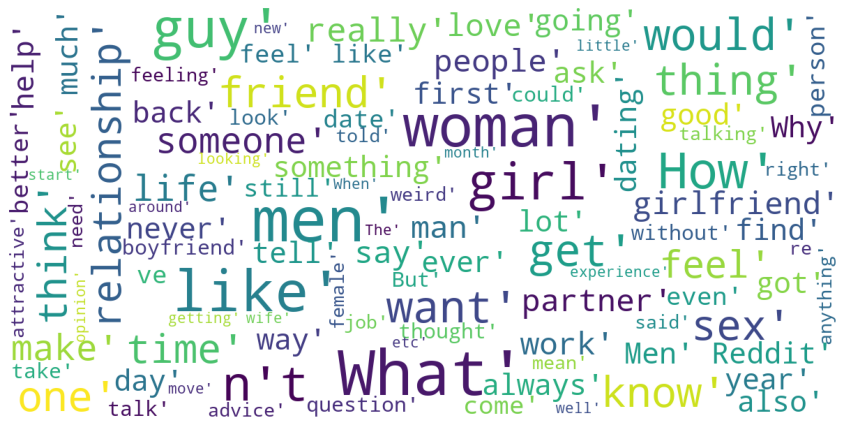

In [51]:
plot_wordcloud(df_askmen['title + selftext'])

In [52]:
df_askmen[df_askmen['title + selftext'].str.len()<15]

,subreddit,author,title,selftext,title + selftext
101,AskMen,Patient_Ad_7265,Help,,Help
113,AskMen,PsychologicalBee2031,Help me.,,Help me.
137,AskMen,No_Victory_1513,Cooking,,Cooking
142,AskMen,Amazing_Artichoke_78,Miss My ex,,Miss My ex
186,AskMen,lykme2,Why???,,Why???
235,AskMen,NewSail752,Girlfriend,,Girlfriend
241,AskMen,shego3,Venting,,Venting
449,AskMen,[deleted],this sucks...,,this sucks...
460,AskMen,Melodic_Drink309,inspiration,,inspiration
468,AskMen,111riot,wha,,wha


In [359]:
#delete rows with len('title + selftext')<15
df_askmen = df_askmen[df_askmen['title + selftext'].str.len()>15]

df1['selftext'].str.len().hist(bins=100)

### Convert subreddit into binary labels:

In [362]:
df = pd.concat(objs=[df_askwomen,df_askmen], axis=0) 
df = df.reset_index(drop=True)

In [363]:

df['subreddit'] = df['subreddit'].map({'AskWomen' : 0, 'AskMen' : 1})
df.head()

,subreddit,author,title,selftext,title + selftext
0,0,lizzyfletch,"""Never date a coworker"" - what are your though...",,"""Never date a coworker"" - what are your though..."
1,0,Severefan,"""Price of Admission"" in relationships: what do...",,"""Price of Admission"" in relationships: what do..."
2,0,tommybuttsecks,( How) those of you that can cum from penetrat...,,( How) those of you that can cum from penetrat...
3,0,Particular-Dream6381,(25m) I’ve found myself in a situation where I...,,(25m) I’ve found myself in a situation where I...
4,0,Dry-Vehicle-8038,10k steps a day challenge - how do you motivat...,,10k steps a day challenge - how do you motivat...


In [364]:
X = df['title + selftext']
y = df['subreddit']

In [365]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

0   0.50
1   0.50
Name: subreddit, dtype: float64

## Pre-Processing

In [366]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=555)

# Matrics
- to use ROC AUC to compare models
- our data is balanced
- Both positive and negative are the same important to us

## Modeling Using the TfidfVectorizer + RandomForest

In [367]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_rf = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('rf',RandomForestClassifier(random_state=42))
                    ])

In [368]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_rf_params = {
                    #params of TfidfVectorizer
                    'tvec__max_features': [500, 1_000, 2_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    #params of random forest
                    'rf__n_estimators' : [500, 1000, 1500],
                    'rf__max_depth' : [1, 2, 3],
                    'rf__class_weight' : [None, {0:1,1:5}]
                    }

In [369]:
# Instantiate GridSearchCV.
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, # what object are we optimizing?
                        param_grid = pipe_tvec_rf_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )


{'rf__class_weight': None, 'rf__max_depth': 3, 'rf__n_estimators': 1000, 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.825
score on testing set: 0.787
perc_diff: 4.7 %
                 pred AskWomen  pred AskMen
actual AskWomen            561           88
actual AskMen              282          357


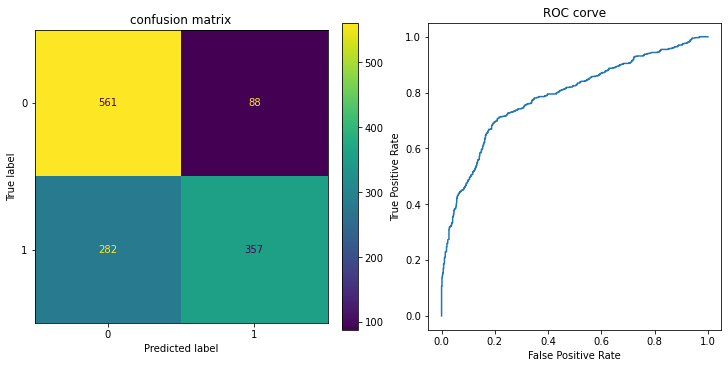

In [370]:
print('')
run_model(gs_tvec_rf, X_train, y_train, X_test, y_test )

## Modeling Using the CountVectorizer + Multinomial Naive Bayes

In [371]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_cvec_mnb = Pipeline([
                ('cvec', CountVectorizer()),
                ('mnb', MultinomialNB())
                ])

In [372]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_cvec_mnb_params = {
                'cvec__max_features': [500, 1_000, 2_000, 3_000, 4_000, 5_000],
                'cvec__min_df': [2, 3],
                'cvec__max_df': [.9, .95],
                'cvec__ngram_range': [(1,1), (1,2)]
                }

In [373]:
# Instantiate GridSearchCV.
gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb, # what object are we optimizing?
                  param_grid=pipe_cvec_mnb_params, # what parameters values are we searching?
                  n_jobs = -1,
                  scoring='roc_auc',
                  cv=3) # 5-fold cross-validation


{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
score on training set: 0.923
score on testing set: 0.779
perc_diff: 15.7 %
                 pred AskWomen  pred AskMen
actual AskWomen            505          144
actual AskMen              231          408


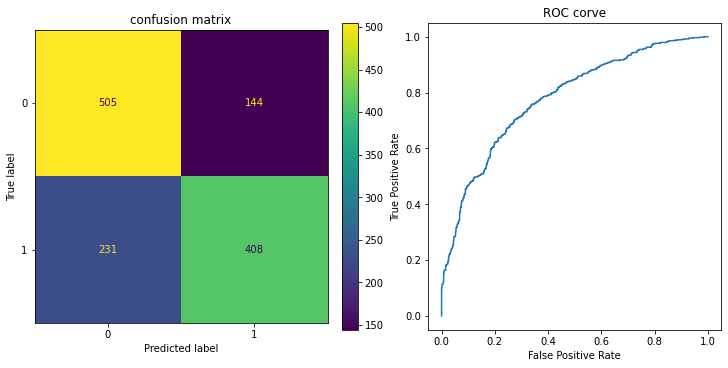

In [374]:
print('')
run_model(gs_cvec_mnb, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + Multinomial Naive Bayes

In [375]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_nb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('mnb', MultinomialNB())
                    ])

In [376]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_nb_params = {
                    'tvec__max_features': [500, 1_000,2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
                    'mnb__alpha' : [10**0, 10**1, 10**2]
                    }

In [377]:
# Instantiate GridSearchCV.
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # what object are we optimizing?
                        param_grid = pipe_tvec_nb_params, # what parameters values are we searching?
                       cv=5, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'mnb__alpha': 10, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.887
score on testing set: 0.792
perc_diff: 10.7 %
                 pred AskWomen  pred AskMen
actual AskWomen            485          164
actual AskMen              209          430


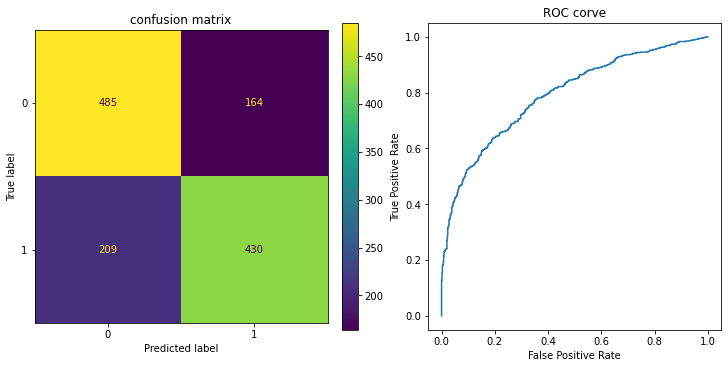

In [378]:
run_model(gs_tvec_nb, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + Bagging Complement Naive Bayes

bagging_nb = BaggingClassifier(GaussianNB(), 
                               n_estimators=100, 
                               max_samples=1.0, 
                               max_features=5, 
                               bootstrap = True, 
                               bootstrap_features = True, 
                               random_state=0)

In [383]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_bagcnb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('bagcnb', BaggingClassifier(ComplementNB()))
                    ])

In [384]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_bagcnb_params = {
                    'tvec__max_features': [500, 1_000, 2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'bagcnb__n_estimators' : [1000, 1500],
                    'bagcnb__max_samples' : [50,100, 150],
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [385]:
# Instantiate GridSearchCV.
gs_tvec_bagcnb = GridSearchCV(pipe_tvec_bagcnb, # what object are we optimizing?
                        param_grid = pipe_tvec_bagcnb_params, # what parameters values are we searching?
                        cv=5, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'bagcnb__max_samples': 150, 'bagcnb__n_estimators': 1500, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.864
score on testing set: 0.788
perc_diff: 8.9 %
                 pred AskWomen  pred AskMen
actual AskWomen            461          188
actual AskMen              186          453


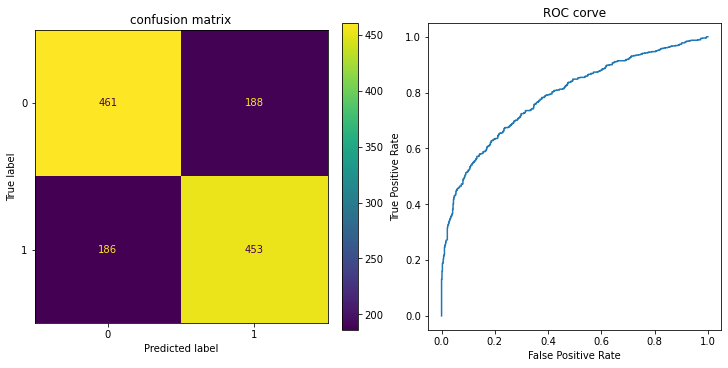

In [386]:
run_model(gs_tvec_bagcnb, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + SVM

In [387]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_svc = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('svc', SVC(probability=True, random_state=42))
                    ])

In [408]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_svc_params = {
                    'tvec__max_features': [100,150,200,300],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    
    
                     #params of bagging naive bayes
                    'svc__C' : [10**-1, 10**0, 10**1],
                    'svc__class_weight' : [None, {0:1,1:5}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [389]:
# Instantiate GridSearchCV.
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # what object are we optimizing?
                        param_grid = pipe_tvec_svc_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'svc__C': 1, 'svc__class_weight': None, 'tvec__max_features': 400, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}
score on training set: 0.974
score on testing set: 0.818
perc_diff: 16.0 %
                 pred AskWomen  pred AskMen
actual AskWomen            529          120
actual AskMen              199          440


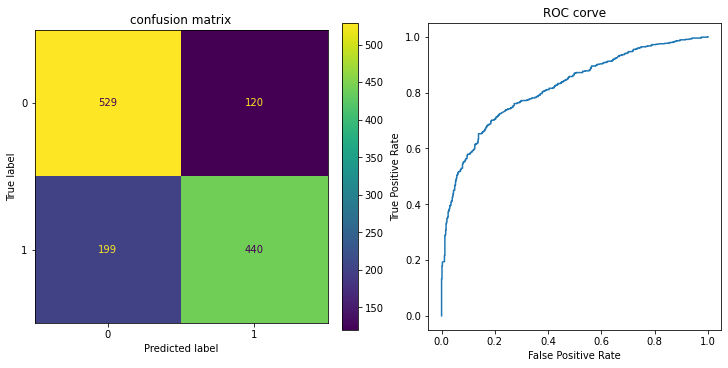

In [409]:
run_model(gs_tvec_svc, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + LogisticRegression

In [391]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_lr = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', LogisticRegression(solver='liblinear'))
                    ])

In [392]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_lr_params = {
                    'tvec__max_features': [1_000,2_000,2_500],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__C' :  [10**-2, 10**-1, 10**0, 10**1, 10**2],
                    'classifier__penalty'  : ['l1','l2'],
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [393]:
# Instantiate GridSearchCV.
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # what object are we optimizing?
                        param_grid = pipe_tvec_lr_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'classifier__C': 1, 'classifier__penalty': 'l1', 'tvec__max_features': 1000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.851
score on testing set: 0.816
perc_diff: 4.1 %
                 pred AskWomen  pred AskMen
actual AskWomen            508          141
actual AskMen              185          454


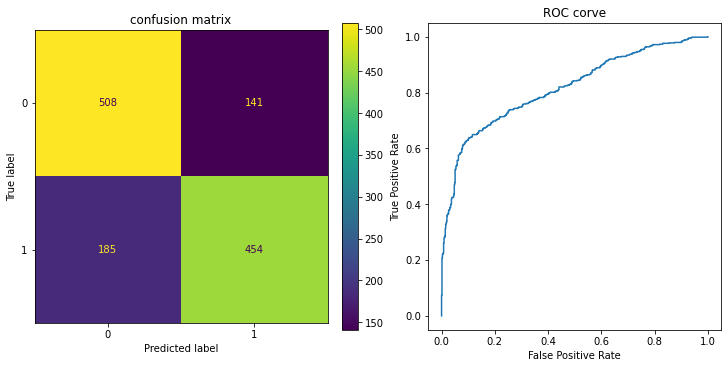

In [394]:
run_model(gs_tvec_lr, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + GradientBoosting

In [395]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_gb = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', GradientBoostingClassifier(random_state=42))
                    ])

In [396]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_gb_params = {
                    'tvec__max_features': [1_000,1_500],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_estimators' : [100, 250,500],
                    'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [397]:
# Instantiate GridSearchCV.
gs_tvec_gb = GridSearchCV(pipe_tvec_gb, # what object are we optimizing?
                        param_grid = pipe_tvec_gb_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'classifier__max_depth': 2, 'classifier__n_estimators': 250, 'tvec__max_features': 1500, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.919
score on testing set: 0.814
perc_diff: 11.5 %
                 pred AskWomen  pred AskMen
actual AskWomen            545          104
actual AskMen              195          444


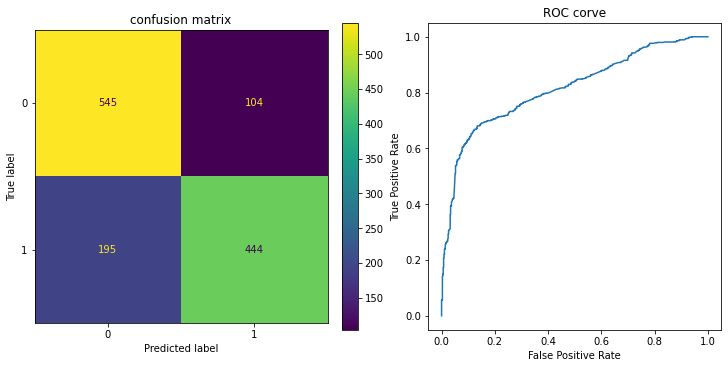

In [398]:
run_model(gs_tvec_gb, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer + AdaBoostClassifier

In [399]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_ab = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', AdaBoostClassifier(random_state=42))
                    ])

In [400]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_ab_params = {
                    'tvec__max_features': [700, 1_000,1_500,2_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_estimators' : [100, 250],
                   # 'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [401]:
# Instantiate GridSearchCV.
gs_tvec_ab = GridSearchCV(pipe_tvec_ab, # what object are we optimizing?
                        param_grid = pipe_tvec_ab_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'classifier__n_estimators': 100, 'tvec__max_features': 1500, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}
score on training set: 0.913
score on testing set: 0.794
perc_diff: 13.0 %
                 pred AskWomen  pred AskMen
actual AskWomen            500          149
actual AskMen              196          443


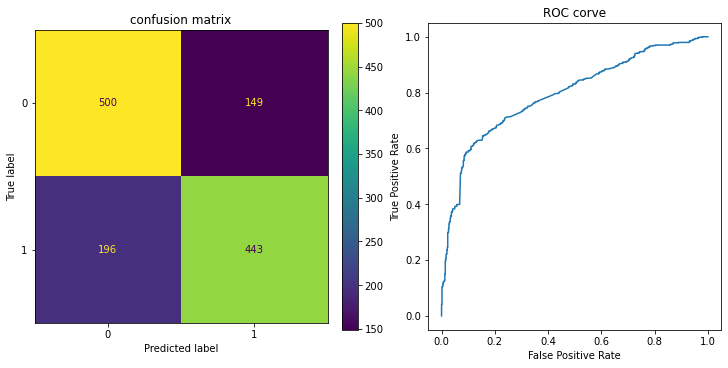

In [402]:
run_model(gs_tvec_ab, X_train, y_train, X_test, y_test )

## Modeling Using the TfidfVectorizer +KNN

In [403]:
from sklearn.neighbors import KNeighborsClassifier

In [404]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes
pipe_tvec_knn = Pipeline([
                    ('tvec', TfidfVectorizer()),
                    ('classifier', KNeighborsClassifier())
                    ])

In [405]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_tvec_knn_params = {
                    'tvec__max_features': [ 1_500,2_000, 3_000],
                    'tvec__stop_words': [None, 'english'],
                    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    
    
                     #params of bagging naive bayes
                    'classifier__n_neighbors' : [10,25,50]
                   # 'classifier__max_depth' : [1,2]
                   # 'classifier__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                   # 'bagging_nb__max_samples' : [1, 5, 10],
                  #  'bagging_nb__max_samples' : [1, 5, 10],
                   # 'bagging_nb__class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }

In [406]:
# Instantiate GridSearchCV.
gs_tvec_knn = GridSearchCV(pipe_tvec_knn, # what object are we optimizing?
                        param_grid = pipe_tvec_knn_params, # what parameters values are we searching?
                        cv=3, # 3-fold cross-validation.
                        n_jobs=-1, 
                        scoring='roc_auc'
                         )

{'classifier__n_neighbors': 50, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
score on training set: 0.774
score on testing set: 0.754
perc_diff: 2.6 %
                 pred AskWomen  pred AskMen
actual AskWomen            309          340
actual AskMen              107          532


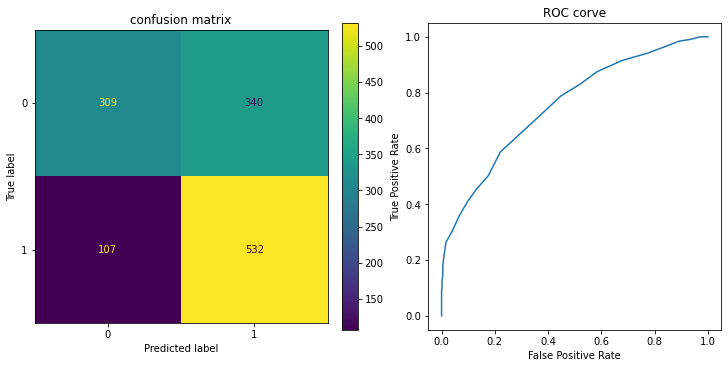

In [407]:
run_model(gs_tvec_knn, X_train, y_train, X_test, y_test )

## Conclusions and Recommendations

- We built several models and found lasso models had the best performance
- Based on the lasso model, we analyzed and found ' BsmtFin SF 1' and 'Fireplaces' as  recommended features for home improvements
- We built models for selected neighborhoods and  recommended some feature for home improvement
- The neighorhood models also suggest that it is better to do home improvement for newer houses or high value houses because it can create more value 

## Limitation and Future Enhancement
- Our 3 multiple regression models have very similar performance, indicating our model might be underfitting, adding more futures may increase model performance
- Our models cannot meet the LINE assumption, other non-regression models should be considered
- Many data are highly imbalance and barely useful. Data collector might redesign what to be collected in the future
- Many neigbhorhoods have insufficient data to build meaningful models. More data is needed